Saving 2.jpg to 2.jpg
Saving 0.jpg to 0.jpg
Saving 1.jpg to 1.jpg
Saving 3.jpg to 3.jpg
3
1
2
0


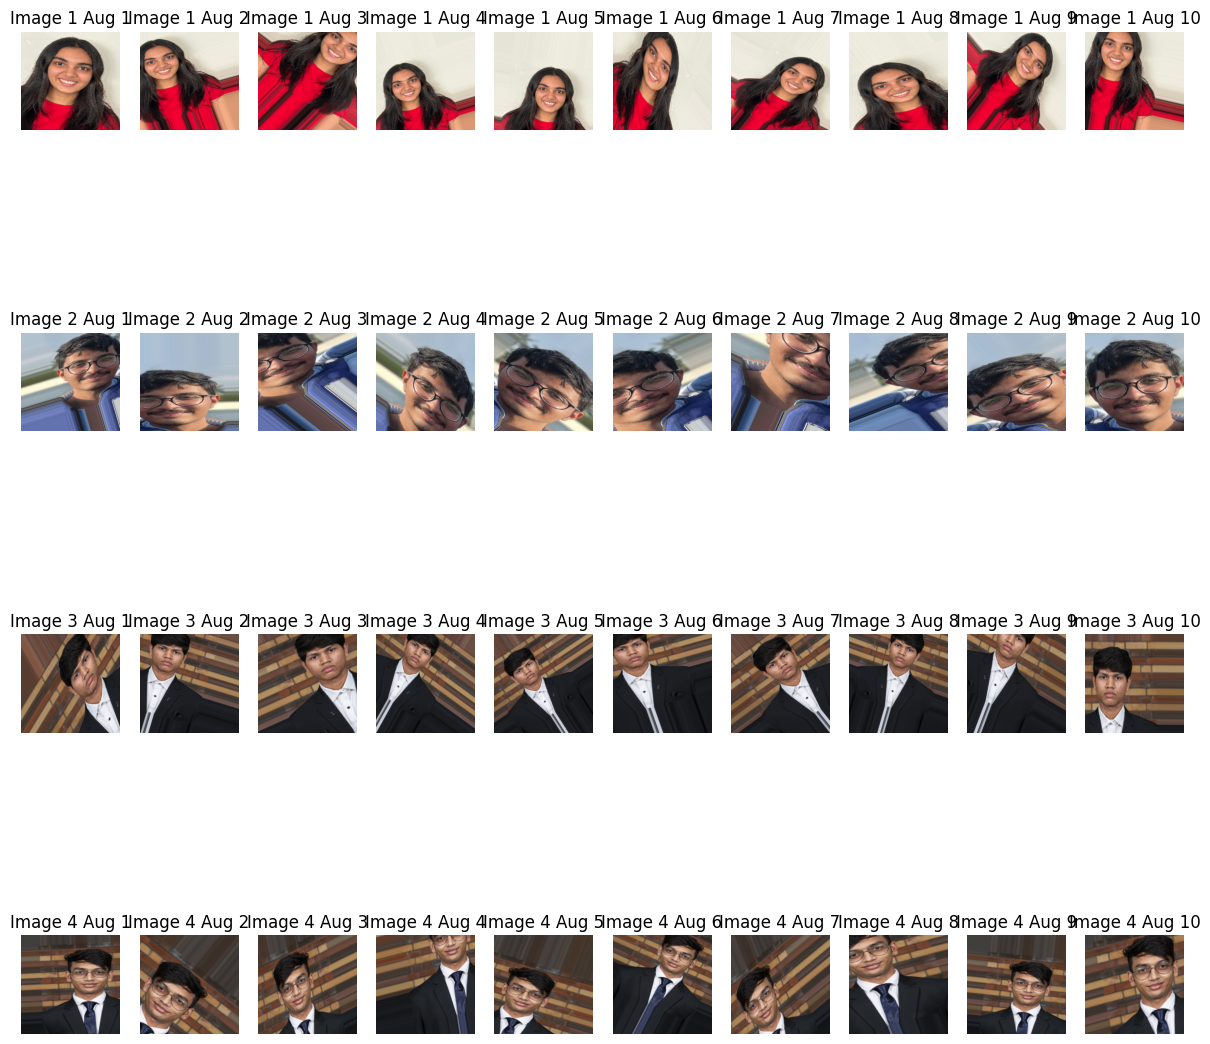

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 46.0784 - accuracy: 0.1875 - val_loss: 22.7845 - val_accuracy: 0.3750
Epoch 2/20
1/1 [==============================] - 1s 840ms/step - loss: 27.2909 - accuracy: 0.2500 - val_loss: 20.3542 - val_accuracy: 0.6250
Epoch 3/20
1/1 [==============================] - 1s 842ms/step - loss: 22.8073 - accuracy: 0.3750 - val_loss: 20.0847 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 859ms/step - loss: 20.5850 - accuracy: 0.5000 - val_loss: 20.1545 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 20.6178 - accuracy: 0.3750 - val_loss: 19.9588 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 1s 849ms/step - loss: 19.9007 - accuracy: 0.5000 - val_loss: 19.5924 - val_accuracy: 0.7500
Epoch 7/20
1/1 [==============================] - 1s 855ms/step - loss: 19.7721 - accuracy: 0.4062 - val_loss: 19.3931 - val_accuracy: 0.6250
Epoch 8/20
1

In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Upload images
uploaded = files.upload()

#  Create a folder to store the uploaded images
dataset_folder = 'dataset'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

for filename in uploaded.keys():
    os.rename(filename, os.path.join(dataset_folder, filename))

image_files = [file for file in os.listdir(dataset_folder) if file.lower().endswith(('.jfif', '.jpg', '.jpeg', '.png'))]
if len(image_files) == 0:
    raise ValueError("No images found in the dataset folder with the supported extensions (.jfif, .jpg, .jpeg, .png)")

num_classes = 5

labels = []
for image_file in image_files:

    print(os.path.splitext(image_file.split()[0])[0])
    label = int(os.path.splitext(image_file.split()[0])[0]) % num_classes  # Extract label from filename
    labels.append(label)

target_size = (224, 224)
num_augmented_images = 10
batch_size = 4 * num_augmented_images

images = []

for image_file in image_files:
    img = cv2.imread(os.path.join(dataset_folder, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    images.append(img)

if len(images) == 0:
    raise ValueError("No images found in the dataset folder")

images = np.array(images)

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for img in images:
    augmented_img_set = []
    for _ in range(num_augmented_images):
        augmented_img_generator = datagen.flow(np.expand_dims(img, axis=0), batch_size=1)
        augmented_img = augmented_img_generator.next()[0].astype('uint8')
        augmented_img_set.append(augmented_img)
    augmented_images.append(augmented_img_set)

plt.figure(figsize=(15, 15))
for i, img_set in enumerate(augmented_images):
    for j, augmented_img in enumerate(img_set):
        plt.subplot(len(augmented_images), num_augmented_images, i*num_augmented_images + j + 1)
        plt.imshow(augmented_img)
        plt.title("Image " + str(i+1) + " Aug " + str(j+1))
        plt.axis('off')
plt.show()

augmented_images_flat = [aug_img for img_set in augmented_images for aug_img in img_set]
augmented_images_flat = np.array(augmented_images_flat)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(augmented_images_flat,
                                                  np.repeat(labels, num_augmented_images),
                                                  test_size=0.2,
                                                  random_state=42)

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=20,
                    validation_data=(X_val, y_val))

model.save('facial_classifier_model_vgg16_finetuned.h5')




Saving test.jpg to test.jpg
1/1 [==============================] - 0s 148ms/step


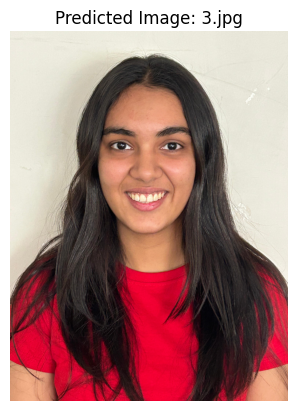

Predicted Class Label: 3
Predicted Class Name: 3.jpg


In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files
import matplotlib.pyplot as plt
import re

uploaded_test_image = files.upload()

model = load_model('facial_classifier_model_vgg16_finetuned.h5')

dataset_folder = 'dataset'
image_files = [file for file in os.listdir(dataset_folder) if file.lower().endswith(('.jfif', '.jpg', '.jpeg', '.png'))]
class_labels = []
for filename in image_files:
    match = re.search(r'\d+', filename)
    if match:
        label = int(match.group())
        class_labels.append(label)
    else:
        print("Warning: Unable to extract label from filename:", filename)

for filename in uploaded_test_image.keys():
    test_img = cv2.imread(filename)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, target_size)
    test_img = np.expand_dims(test_img, axis=0)

predictions = model.predict(test_img)

predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_image_filename = image_files[predicted_class_index]

predicted_image = cv2.imread(os.path.join(dataset_folder, predicted_image_filename))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

plt.imshow(predicted_image)
plt.title("Predicted Image: " + predicted_image_filename)
plt.axis('off')
plt.show()

print("Predicted Class Label:", predicted_class_label)
print("Predicted Class Name:", predicted_image_filename)



